In [61]:
import xarray as xr
import pickle 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point
from eofs.multivariate.iris import MultivariateEof
import iris
import iris.plot as iplt
import iris.quickplot as qplt
import datetime

In [337]:
path = "/mnt/c/Users/susaw/Desktop/Klima/*.nc"

In [338]:
#Files öffnen und umbennenen 
def open_data(path):
    df = xr.open_mfdataset(path,chunks={'initial_time0_hours':504,'g0_lat_1':29,'g0_lon_2':29})
    df = df.rename({'initial_time0_hours':'time','g0_lat_1':'lat','g0_lon_2':'lon'}).drop("initial_time0_encoded")
    df.coords['lon'] = (df.coords['lon'] + 180) % 360 - 180
    return df

In [339]:
#Anomalien berechnen
def calc_normalized_anomalies(ds_prep, window_size=21):

    # Resample with mean over data if temporal resolution is higher than daily (Lower resolution not supported here)
    if pd.infer_freq(ds_prep.time.data) not in 'D':
        ds_prep = ds_prep.resample(time='1D').mean()
        ds_prep = ds_prep.chunk({'time':-1})

    # calculates the climatology and the standard deviation for further anomaly calculation
    ds_prep_roll = ds_prep.rolling(time=window_size, center=True).construct('window_dim') # creates the rolling window as a new dimension

    # mean after construct without dropna: first and last windows are considered, even if there are timesteps with missing values
    ds_prep_clim = ds_prep_roll.groupby('time.dayofyear').mean(dim=['window_dim','time'])

    # calculate standard deviation (dayofyear std) for rolling window over Target Day ± 10days (pool)
    ds_prep_std = ds_prep_roll.groupby('time.dayofyear').std(dim=xr.ALL_DIMS) # Calculates the std for dayofyear of TD + pool, shape(365,)

    # calculate daily normalized anomalies with mean and std from TD + pool
    ds_prep = ds_prep.groupby('time.dayofyear') - ds_prep_clim
    ds_prep = ds_prep.groupby('time.dayofyear') / ds_prep_std

    # Rechunking necessary after groupby
    ds_prep = ds_prep.chunk({'time': -1})

    return ds_prep

In [340]:
df = open_data(path)
df


KeyboardInterrupt



In [ ]:
df = df.rename({["PRMSL_GDS0_MSL","mslp"][0]:["PRMSL_GDS0_MSL","mslp"][1],["RH_GDS0_ISBL","rh"][0]:["RH_GDS0_ISBL","rh"][1],["SPFH_GDS0_ISBL","spfh"][0]:["SPFH_GDS0_ISBL","spfh"][1]}).drop("initial_time0")
anomalies_norm = calc_normalized_anomalies(df)
anomalies_norm

In [9]:
#anomalies_norm.to_netcdf(path='/mnt/c/Users/susaw/Desktop/anomalien.nc')

In [341]:
anomalies_norm = xr.open_dataset("/mnt/c/Users/susaw/Desktop/anomalien.nc",chunks={'time': 30000, 'lat':141, 'lon': 141})
anomalies_norm

<xarray.Dataset>
Dimensions:    (lat: 29, lon: 29, time: 22280)
Coordinates:
  * lat        (lat) float32 67.5 66.25 65.0 63.75 ... 36.25 35.0 33.75 32.5
  * lon        (lon) float32 -10.0 -8.75 -7.5 -6.25 ... 21.25 22.5 23.75 25.0
  * time       (time) datetime64[ns] 1958-01-01 1958-01-02 ... 2018-12-31
    dayofyear  (time) int64 dask.array<shape=(22280,), chunksize=(22280,)>
Data variables:
    mslp       (time, lat, lon) float32 dask.array<shape=(22280, 29, 29), chunksize=(22280, 29, 29)>
    rh         (time, lat, lon) float32 dask.array<shape=(22280, 29, 29), chunksize=(22280, 29, 29)>
    spfh       (time, lat, lon) float32 dask.array<shape=(22280, 29, 29), chunksize=(22280, 29, 29)>

### Plots Anomalien

##### Plots von 31.12.2017(21915) und seinem Analogon dem 8.1.1991(12060) (berechnet weiter unten!!!)

Text(0.5, 1.0, 'RH Anomalien 8.1.1991')

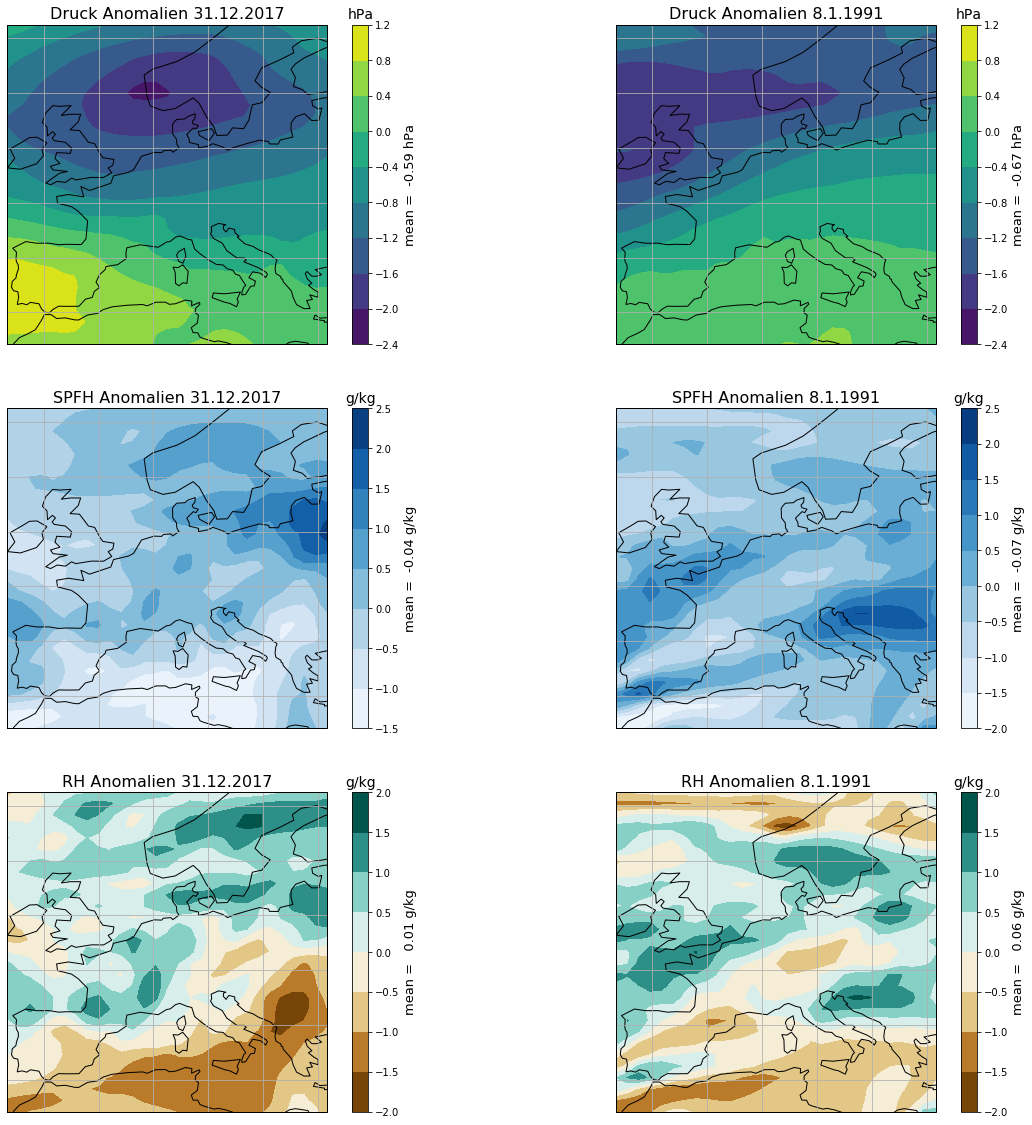

In [60]:
f=plt.figure(figsize=(20,20))

ax = plt.subplot(3,2,1,projection=ccrs.PlateCarree(central_longitude=0))
p = ax.contourf(anomalies_norm.variables['lon'][:],anomalies_norm.variables['lat'][:],anomalies_norm.mslp[21915,:,:],transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
clb = plt.colorbar(p,ax=ax, orientation='vertical')
clb.ax.set_title('hPa',size=14)
clb.set_label('mean = ' + '{:6.2f}'.format(np.mean(anomalies_norm.mslp[21915,:,:].values)) + ' hPa',size=13)
plt.title('Druck Anomalien 31.12.2017', fontsize=16)


ax = plt.subplot(3,2,2,projection=ccrs.PlateCarree(central_longitude=0))
clevs = [-2.4,-2.0,-1.6,-1.2,-0.8,-0.4,0.0,0.4,0.8,1.2]
p = ax.contourf(anomalies_norm.variables['lon'][:],anomalies_norm.variables['lat'][:],anomalies_norm.mslp[12060,:,:],clevs,transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
clb = plt.colorbar(p,ax=ax, orientation='vertical')
clb.ax.set_title('hPa', size=14)
clb.set_label('mean = ' + '{:6.2f}'.format(np.mean(anomalies_norm.mslp[12060,:,:].values)) + ' hPa',size=13)
plt.title('Druck Anomalien 8.1.1991', fontsize=16)


ax = plt.subplot(3,2,3,projection=ccrs.PlateCarree(central_longitude=0))
p = ax.contourf(anomalies_norm.variables['lon'][:],anomalies_norm.variables['lat'][:],anomalies_norm.spfh[21915,:,:],transform=ccrs.PlateCarree(),cmap='Blues')
ax.coastlines()
ax.gridlines()
clb = plt.colorbar(p,ax=ax, orientation='vertical')
clb.ax.set_title('g/kg',size=14)
clb.set_label('mean = ' + '{:6.2f}'.format(np.mean(anomalies_norm.spfh[21915,:,:].values)) + ' g/kg',size=13)
plt.title('SPFH Anomalien 31.12.2017', fontsize=16)


ax = plt.subplot(3,2,4,projection=ccrs.PlateCarree(central_longitude=0))
clevs = [-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2.0, 2.5]
p = ax.contourf(anomalies_norm.variables['lon'][:],anomalies_norm.variables['lat'][:],anomalies_norm.spfh[12060,:,:],clevs,transform=ccrs.PlateCarree(),cmap='Blues')
ax.coastlines()
ax.gridlines()
clb = plt.colorbar(p,ax=ax, orientation='vertical')
clb.ax.set_title('g/kg', size=14)
clb.set_label('mean = ' + '{:6.2f}'.format(np.mean(anomalies_norm.spfh[12060,:,:].values)) + ' g/kg',size=13)
plt.title('SPFH Anomalien 8.1.1991', fontsize=16)


ax = plt.subplot(3,2,5,projection=ccrs.PlateCarree(central_longitude=0))
p = ax.contourf(anomalies_norm.variables['lon'][:],anomalies_norm.variables['lat'][:],anomalies_norm.rh[21915,:,:],transform=ccrs.PlateCarree(),cmap='BrBG')
ax.coastlines()
ax.gridlines()
clb = plt.colorbar(p,ax=ax, orientation='vertical')
clb.ax.set_title('g/kg',size=14)
clb.set_label('mean = ' + '{:6.2f}'.format(np.mean(anomalies_norm.rh[21915,:,:].values)) + ' g/kg',size=13)
plt.title('RH Anomalien 31.12.2017', fontsize=16)


ax = plt.subplot(3,2,6,projection=ccrs.PlateCarree(central_longitude=0))
clevs = [-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2.0]
p = ax.contourf(anomalies_norm.variables['lon'][:],anomalies_norm.variables['lat'][:],anomalies_norm.rh[12060,:,:],clevs,transform=ccrs.PlateCarree(),cmap='BrBG')
ax.coastlines()
ax.gridlines()
clb = plt.colorbar(p,ax=ax, orientation='vertical')
clb.ax.set_title('g/kg', size=14)
clb.set_label('mean = ' + '{:6.2f}'.format(np.mean(anomalies_norm.rh[12060,:,:].values)) + ' g/kg',size=13)
plt.title('RH Anomalien 8.1.1991', fontsize=16)

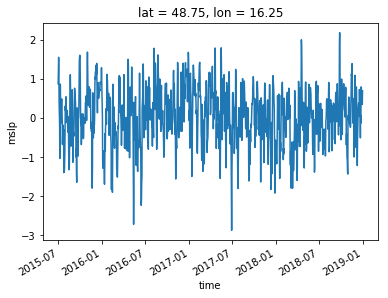

In [174]:
anomalies_norm.mslp[21000:24000,15,21].plot()

In [65]:
result = pd.DataFrame(columns=['search_day', 'found_day'])
N_list=np.array([])
var_f_list=np.array([])
for doy in range(1,367):   # Loop über alle 366 dayofyears wenn: range(1,367):
    print('berechne doy: ', doy) # = Target Day
    
    # Bestimmen der benötigten doy im Zeitfenster
    days = np.arange(doy-10,doy+11)
    days[days<=0] = days[days<=0]+366
    days[days>366] = days[days>366]-366
    
    # Ausschneiden der 21 Tage (in allen Jahren), Größe: 21 Tage x 40 Jahre x 141x141
    anomalies_i_q = anomalies_norm.spfh.where(anomalies_norm.spfh.dayofyear.isin(days),drop=True).to_iris()
    anomalies_i_r = anomalies_norm.rh.where(anomalies_norm.rh.dayofyear.isin(days),drop=True).to_iris()
    anomalies_i_msl = anomalies_norm.mslp.where(anomalies_norm.mslp.dayofyear.isin(days),drop=True).to_iris()
    
    # solver-Objekt erzeugen
    solver = MultivariateEof([anomalies_i_q,anomalies_i_r,anomalies_i_msl])
    
    # immer mehr PCs bis 90% erklärte Varianz:
    N = 1
    var_f = 0
    while var_f < .9:
        var_f = np.sum(solver.varianceFraction(neigs=N).data)
        N = N+1
    N_list = np.append(N_list,N)
    var_f_list = np.append(var_f_list,var_f)
    pcs = solver.pcs(npcs=N)
    pcs_x = xr.DataArray.from_iris(pcs) # Umwandeln der PCs in xarray
    del pcs    
        
    for year in np.arange(1958,2018): # Loop über die 40 Jahre
        
        # Ausschneiden der einen benötigten Analyse (= ein Tag), Größe: 141x141
        single_q = anomalies_norm.spfh.sel(time=((anomalies_norm.time.dt.year == year)&(anomalies_norm.dayofyear == doy))).to_iris()
        single_r = anomalies_norm.rh.sel(time=((anomalies_norm.time.dt.year == year)&(anomalies_norm.dayofyear == doy))).to_iris()
        single_msl = anomalies_norm.mslp.sel(time=((anomalies_norm.time.dt.year == year)&(anomalies_norm.dayofyear == doy))).to_iris()
        
        if single_q.coord('time').points.size > 0:  # nur wenn der doy in dem Jahr existiert (doy 366 nur in Schaltjahren)
            
            # Berechnen der Pseudo-PCs für den einen Tag
            pseudo_pcs = solver.projectField([single_q, single_r, single_msl], neofs=N)
        
            # Minimieren der Norm (=Suchen des analogen Tags = 'found_day')
            found_idx=np.argmin(np.sum(np.sqrt((pcs_x.sel(time=~(pcs_x.time.dt.year == year)).data - pseudo_pcs.data)**2),axis=1)) # Index im pcs
        
            search_day = anomalies_norm.sel(time=((anomalies_norm.time.dt.year == year)&(anomalies_norm.dayofyear == doy))).time[0].data # 'aktueller Tag'
            found_day = pcs_x.sel(time=~(pcs_x.time.dt.year == year)).isel(time=found_idx).time.data
            
            result = result.append(pd.DataFrame([[pd.to_datetime(search_day),pd.to_datetime(found_day)]],columns=['search_day', 'found_day']))

berechne doy:  1
berechne doy:  2
berechne doy:  3
berechne doy:  4
berechne doy:  5
berechne doy:  6
berechne doy:  7
berechne doy:  8
berechne doy:  9
berechne doy:  10
berechne doy:  11
berechne doy:  12
berechne doy:  13
berechne doy:  14
berechne doy:  15
berechne doy:  16
berechne doy:  17
berechne doy:  18
berechne doy:  19
berechne doy:  20
berechne doy:  21
berechne doy:  22
berechne doy:  23
berechne doy:  24
berechne doy:  25
berechne doy:  26
berechne doy:  27
berechne doy:  28
berechne doy:  29
berechne doy:  30
berechne doy:  31
berechne doy:  32
berechne doy:  33
berechne doy:  34
berechne doy:  35
berechne doy:  36
berechne doy:  37
berechne doy:  38
berechne doy:  39
berechne doy:  40
berechne doy:  41
berechne doy:  42
berechne doy:  43
berechne doy:  44
berechne doy:  45
berechne doy:  46
berechne doy:  47
berechne doy:  48
berechne doy:  49
berechne doy:  50
berechne doy:  51
berechne doy:  52
berechne doy:  53
berechne doy:  54
berechne doy:  55
berechne doy:  56
b

In [343]:
result = result.sort_values('search_day') # richtige Reihenfolge machen
pickle.dump(result, open( "save_found_dates.p", "wb" ) )
pickle.dump(N_list, open( "save_N_list.p", "wb" ) )
pickle.dump(var_f_list, open( "save_var_f_list.p", "wb" ) )

In [344]:
dates=pickle.load( open( "save_found_dates.p", "rb" ) )
dates

,search_day,found_day
0,1958-01-01,1977-01-10
0,1958-01-02,1976-12-24
0,1958-01-03,1976-12-24
0,1958-01-04,2010-12-29
0,1958-01-05,1966-12-28
0,1958-01-06,2018-01-16
0,1958-01-07,1959-01-15
0,1958-01-08,1977-12-31
0,1958-01-09,1999-01-14
0,1958-01-10,1999-01-13


In [66]:
eofs_list = solver.eofsAsCorrelation(neofs=N)

In [67]:
eofs_list

[<iris 'Cube' of correlation_between_pcs_and_spfh / (unknown) (eof_number: 49; latitude: 29; lon: 29)>,
 <iris 'Cube' of correlation_between_pcs_and_rh / (unknown) (eof_number: 49; latitude: 29; lon: 29)>,
 <iris 'Cube' of correlation_between_pcs_and_mslp / (unknown) (eof_number: 49; latitude: 29; lon: 29)>]

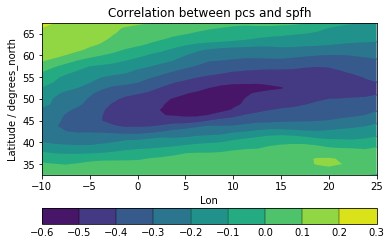

In [352]:
qplt.contourf(eofs_list[0][0])
plt.show()

In [69]:
eof=solver.eofs(neofs=N)
eof

[<iris 'Cube' of empirical_orthogonal_functions / (unknown) (eof_number: 49; latitude: 29; lon: 29)>,
 <iris 'Cube' of empirical_orthogonal_functions / (unknown) (eof_number: 49; latitude: 29; lon: 29)>,
 <iris 'Cube' of empirical_orthogonal_functions / (unknown) (eof_number: 49; latitude: 29; lon: 29)>]

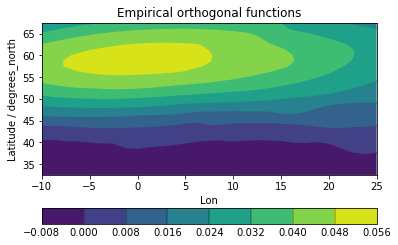

In [182]:
qplt.contourf(eof[2][0])
plt.show()

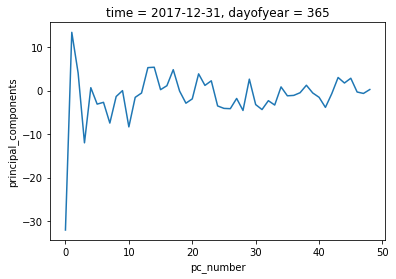

In [198]:
pcs_x[1214,:].plot()

In [365]:
pcs=solver.pcs(npcs=N)
pcs_x=xr.DataArray.from_iris(pcs)
pcs_x

<xarray.DataArray 'pcs' (time: 1235, pc: 49)>
array([[ -9.813268,  -6.242735,  15.85665 , ...,   1.053399,   1.5308  ,
         -2.281484],
       [  5.806532, -17.707191,   4.060774, ...,  -0.868195,   2.207171,
          0.741803],
       [ 21.364931, -15.785078,  -5.709477, ...,  -0.987691,  -0.297195,
         -0.308851],
       ...,
       [ 17.241919,  18.859377,   6.032184, ...,  -0.07211 ,   3.698493,
         -0.601468],
       [ 17.421556,  18.246851,   9.003103, ...,   1.439217,  -1.153569,
         -1.449812],
       [ 17.660723,  22.016985,   5.485769, ...,  -1.299272,   0.554004,
          2.667228]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1958-01-01 1958-01-02 ... 2018-12-31
  * pc         (pc) int64 0 1 2 3 4 5 6 7 8 9 ... 39 40 41 42 43 44 45 46 47 48
    dayofyear  (time) int64 ...
Attributes:
    long_name:  principal_components

### Felder rekonstruieren aus EOFs und PCs

In [366]:
### Erzeugen der Linearkombinationen EOF_i*PC_i für die rekonstruierten Felder
mslp_rek = xr.DataArray.from_iris(eof[2][0])*pcs_x[1214,0]+xr.DataArray.from_iris(eof[2][1])*pcs_x[1214,1]+xr.DataArray.from_iris(eof[2][2])*pcs_x[1214,2]+xr.DataArray.from_iris(eof[2][3])*pcs_x[1214,3]+xr.DataArray.from_iris(eof[2][4])*pcs_x[1214,4]+xr.DataArray.from_iris(eof[2][5])*pcs_x[1214,5]+xr.DataArray.from_iris(eof[2][6])*pcs_x[1214,6]+xr.DataArray.from_iris(eof[2][7])*pcs_x[1214,7]+xr.DataArray.from_iris(eof[2][8])*pcs_x[1214,8]+xr.DataArray.from_iris(eof[2][9])*pcs_x[1214,9]+xr.DataArray.from_iris(eof[2][10])*pcs_x[1214,10]+xr.DataArray.from_iris(eof[2][11])*pcs_x[1214,11]+xr.DataArray.from_iris(eof[2][12])*pcs_x[1214,12]+xr.DataArray.from_iris(eof[2][13])*pcs_x[1214,13]+xr.DataArray.from_iris(eof[2][14])*pcs_x[1214,14]+xr.DataArray.from_iris(eof[2][15])*pcs_x[1214,15]+xr.DataArray.from_iris(eof[2][16])*pcs_x[1214,16]+xr.DataArray.from_iris(eof[2][17])*pcs_x[1214,17]+xr.DataArray.from_iris(eof[2][18])*pcs_x[1214,18]+xr.DataArray.from_iris(eof[2][19])*pcs_x[1214,19]+xr.DataArray.from_iris(eof[2][20])*pcs_x[1214,20]+xr.DataArray.from_iris(eof[2][21])*pcs_x[1214,21]+xr.DataArray.from_iris(eof[2][22])*pcs_x[1214,22]+xr.DataArray.from_iris(eof[2][23])*pcs_x[1214,23]+xr.DataArray.from_iris(eof[2][24])*pcs_x[1214,24]+xr.DataArray.from_iris(eof[2][25])*pcs_x[1214,25]+xr.DataArray.from_iris(eof[2][26])*pcs_x[1214,26]+xr.DataArray.from_iris(eof[2][27])*pcs_x[1214,27]+xr.DataArray.from_iris(eof[2][28])*pcs_x[1214,28]+xr.DataArray.from_iris(eof[2][29])*pcs_x[1214,29]+xr.DataArray.from_iris(eof[2][30])*pcs_x[1214,30]+xr.DataArray.from_iris(eof[2][31])*pcs_x[1214,31]+xr.DataArray.from_iris(eof[2][32])*pcs_x[1214,32]+xr.DataArray.from_iris(eof[2][33])*pcs_x[1214,33]+xr.DataArray.from_iris(eof[2][34])*pcs_x[1214,34]+xr.DataArray.from_iris(eof[2][35])*pcs_x[1214,35]+xr.DataArray.from_iris(eof[2][36])*pcs_x[1214,36]+xr.DataArray.from_iris(eof[2][37])*pcs_x[1214,37]+xr.DataArray.from_iris(eof[2][38])*pcs_x[1214,38]+xr.DataArray.from_iris(eof[2][39])*pcs_x[1214,39]+xr.DataArray.from_iris(eof[2][40])*pcs_x[1214,40]+xr.DataArray.from_iris(eof[2][41])*pcs_x[1214,41]+xr.DataArray.from_iris(eof[2][42])*pcs_x[1214,42]+xr.DataArray.from_iris(eof[2][43])*pcs_x[1214,43]+xr.DataArray.from_iris(eof[2][44])*pcs_x[1214,44]+xr.DataArray.from_iris(eof[2][45])*pcs_x[1214,45]+xr.DataArray.from_iris(eof[2][46])*pcs_x[1214,46]+xr.DataArray.from_iris(eof[2][47])*pcs_x[1214,47]+xr.DataArray.from_iris(eof[2][48])*pcs_x[1214,48]
rh_rek = xr.DataArray.from_iris(eof[1][0])*pcs_x[1214,0]+xr.DataArray.from_iris(eof[1][1])*pcs_x[1214,1]+xr.DataArray.from_iris(eof[1][2])*pcs_x[1214,2]+xr.DataArray.from_iris(eof[1][3])*pcs_x[1214,3]+xr.DataArray.from_iris(eof[1][4])*pcs_x[1214,4]+xr.DataArray.from_iris(eof[1][5])*pcs_x[1214,5]+xr.DataArray.from_iris(eof[1][6])*pcs_x[1214,6]+xr.DataArray.from_iris(eof[1][7])*pcs_x[1214,7]+xr.DataArray.from_iris(eof[1][8])*pcs_x[1214,8]+xr.DataArray.from_iris(eof[1][9])*pcs_x[1214,9]+xr.DataArray.from_iris(eof[1][10])*pcs_x[1214,10]+xr.DataArray.from_iris(eof[1][11])*pcs_x[1214,11]+xr.DataArray.from_iris(eof[1][12])*pcs_x[1214,12]+xr.DataArray.from_iris(eof[1][13])*pcs_x[1214,13]+xr.DataArray.from_iris(eof[1][14])*pcs_x[1214,14]+xr.DataArray.from_iris(eof[1][15])*pcs_x[1214,15]+xr.DataArray.from_iris(eof[1][16])*pcs_x[1214,16]+xr.DataArray.from_iris(eof[1][17])*pcs_x[1214,17]+xr.DataArray.from_iris(eof[1][18])*pcs_x[1214,18]+xr.DataArray.from_iris(eof[1][19])*pcs_x[1214,19]+xr.DataArray.from_iris(eof[1][20])*pcs_x[1214,20]+xr.DataArray.from_iris(eof[1][21])*pcs_x[1214,21]+xr.DataArray.from_iris(eof[1][22])*pcs_x[1214,22]+xr.DataArray.from_iris(eof[1][23])*pcs_x[1214,23]+xr.DataArray.from_iris(eof[1][24])*pcs_x[1214,24]+xr.DataArray.from_iris(eof[1][25])*pcs_x[1214,25]+xr.DataArray.from_iris(eof[1][26])*pcs_x[1214,26]+xr.DataArray.from_iris(eof[1][27])*pcs_x[1214,27]+xr.DataArray.from_iris(eof[1][28])*pcs_x[1214,28]+xr.DataArray.from_iris(eof[1][29])*pcs_x[1214,29]+xr.DataArray.from_iris(eof[1][30])*pcs_x[1214,30]+xr.DataArray.from_iris(eof[1][31])*pcs_x[1214,31]+xr.DataArray.from_iris(eof[1][32])*pcs_x[1214,32]+xr.DataArray.from_iris(eof[1][33])*pcs_x[1214,33]+xr.DataArray.from_iris(eof[1][34])*pcs_x[1214,34]+xr.DataArray.from_iris(eof[1][35])*pcs_x[1214,35]+xr.DataArray.from_iris(eof[1][36])*pcs_x[1214,36]+xr.DataArray.from_iris(eof[1][37])*pcs_x[1214,37]+xr.DataArray.from_iris(eof[1][38])*pcs_x[1214,38]+xr.DataArray.from_iris(eof[1][39])*pcs_x[1214,39]+xr.DataArray.from_iris(eof[1][40])*pcs_x[1214,40]+xr.DataArray.from_iris(eof[1][41])*pcs_x[1214,41]+xr.DataArray.from_iris(eof[1][42])*pcs_x[1214,42]+xr.DataArray.from_iris(eof[1][43])*pcs_x[1214,43]+xr.DataArray.from_iris(eof[1][44])*pcs_x[1214,44]+xr.DataArray.from_iris(eof[1][45])*pcs_x[1214,45]+xr.DataArray.from_iris(eof[1][46])*pcs_x[1214,46]+xr.DataArray.from_iris(eof[1][47])*pcs_x[1214,47]+xr.DataArray.from_iris(eof[1][48])*pcs_x[1214,48]
slhp_rek = xr.DataArray.from_iris(eof[0][0])*pcs_x[1214,0]+xr.DataArray.from_iris(eof[0][1])*pcs_x[1214,1]+xr.DataArray.from_iris(eof[0][2])*pcs_x[1214,2]+xr.DataArray.from_iris(eof[0][3])*pcs_x[1214,3]+xr.DataArray.from_iris(eof[0][4])*pcs_x[1214,4]+xr.DataArray.from_iris(eof[0][5])*pcs_x[1214,5]+xr.DataArray.from_iris(eof[0][6])*pcs_x[1214,6]+xr.DataArray.from_iris(eof[0][7])*pcs_x[1214,7]+xr.DataArray.from_iris(eof[0][8])*pcs_x[1214,8]+xr.DataArray.from_iris(eof[0][9])*pcs_x[1214,9]+xr.DataArray.from_iris(eof[0][10])*pcs_x[1214,10]+xr.DataArray.from_iris(eof[0][11])*pcs_x[1214,11]+xr.DataArray.from_iris(eof[0][12])*pcs_x[1214,12]+xr.DataArray.from_iris(eof[0][13])*pcs_x[1214,13]+xr.DataArray.from_iris(eof[0][14])*pcs_x[1214,14]+xr.DataArray.from_iris(eof[0][15])*pcs_x[1214,15]+xr.DataArray.from_iris(eof[0][16])*pcs_x[1214,16]+xr.DataArray.from_iris(eof[0][17])*pcs_x[1214,17]+xr.DataArray.from_iris(eof[0][18])*pcs_x[1214,18]+xr.DataArray.from_iris(eof[0][19])*pcs_x[1214,19]+xr.DataArray.from_iris(eof[0][20])*pcs_x[1214,20]+xr.DataArray.from_iris(eof[0][21])*pcs_x[1214,21]+xr.DataArray.from_iris(eof[0][22])*pcs_x[1214,22]+xr.DataArray.from_iris(eof[0][23])*pcs_x[1214,23]+xr.DataArray.from_iris(eof[0][24])*pcs_x[1214,24]+xr.DataArray.from_iris(eof[0][25])*pcs_x[1214,25]+xr.DataArray.from_iris(eof[0][26])*pcs_x[1214,26]+xr.DataArray.from_iris(eof[0][27])*pcs_x[1214,27]+xr.DataArray.from_iris(eof[0][28])*pcs_x[1214,28]+xr.DataArray.from_iris(eof[0][29])*pcs_x[1214,29]+xr.DataArray.from_iris(eof[0][30])*pcs_x[1214,30]+xr.DataArray.from_iris(eof[0][31])*pcs_x[1214,31]+xr.DataArray.from_iris(eof[0][32])*pcs_x[1214,32]+xr.DataArray.from_iris(eof[0][33])*pcs_x[1214,33]+xr.DataArray.from_iris(eof[0][34])*pcs_x[1214,34]+xr.DataArray.from_iris(eof[0][35])*pcs_x[1214,35]+xr.DataArray.from_iris(eof[0][36])*pcs_x[1214,36]+xr.DataArray.from_iris(eof[0][37])*pcs_x[1214,37]+xr.DataArray.from_iris(eof[0][38])*pcs_x[1214,38]+xr.DataArray.from_iris(eof[0][39])*pcs_x[1214,39]+xr.DataArray.from_iris(eof[0][40])*pcs_x[1214,40]+xr.DataArray.from_iris(eof[0][41])*pcs_x[1214,41]+xr.DataArray.from_iris(eof[0][42])*pcs_x[1214,42]+xr.DataArray.from_iris(eof[0][43])*pcs_x[1214,43]+xr.DataArray.from_iris(eof[0][44])*pcs_x[1214,44]+xr.DataArray.from_iris(eof[0][45])*pcs_x[1214,45]+xr.DataArray.from_iris(eof[0][46])*pcs_x[1214,46]+xr.DataArray.from_iris(eof[0][47])*pcs_x[1214,47]+xr.DataArray.from_iris(eof[0][48])*pcs_x[1214,48]

In [367]:
mslp_rek

<xarray.DataArray (lat: 29, lon: 29)>
array([[-0.790111, -0.813839, -0.838444, ..., -0.508764, -0.491823, -0.476349],
       [-0.96108 , -0.985685, -1.010556, ..., -0.537666, -0.521397, -0.509692],
       [-1.13402 , -1.162429, -1.188632, ..., -0.578833, -0.562134, -0.548627],
       ...,
       [ 0.338347,  0.344543,  0.343721, ...,  0.202139,  0.161747,  0.12689 ],
       [ 0.338876,  0.335702,  0.32687 , ...,  0.185334,  0.140872,  0.0995  ],
       [ 0.324841,  0.314096,  0.304348, ...,  0.158009,  0.118653,  0.077809]],
      dtype=float32)
Coordinates:
  * lat        (lat) float32 67.5 66.25 65.0 63.75 ... 36.25 35.0 33.75 32.5
  * lon        (lon) float32 -10.0 -8.75 -7.5 -6.25 ... 21.25 22.5 23.75 25.0
    time       datetime64[ns] 2017-12-31
    dayofyear  int64 365
    eof        int64 ...
    pc         int64 48

#### Plot rek. Felder

Text(0.5, 1.0, 'SPFH Anom. rekonstruiert aus 49 EOFs')

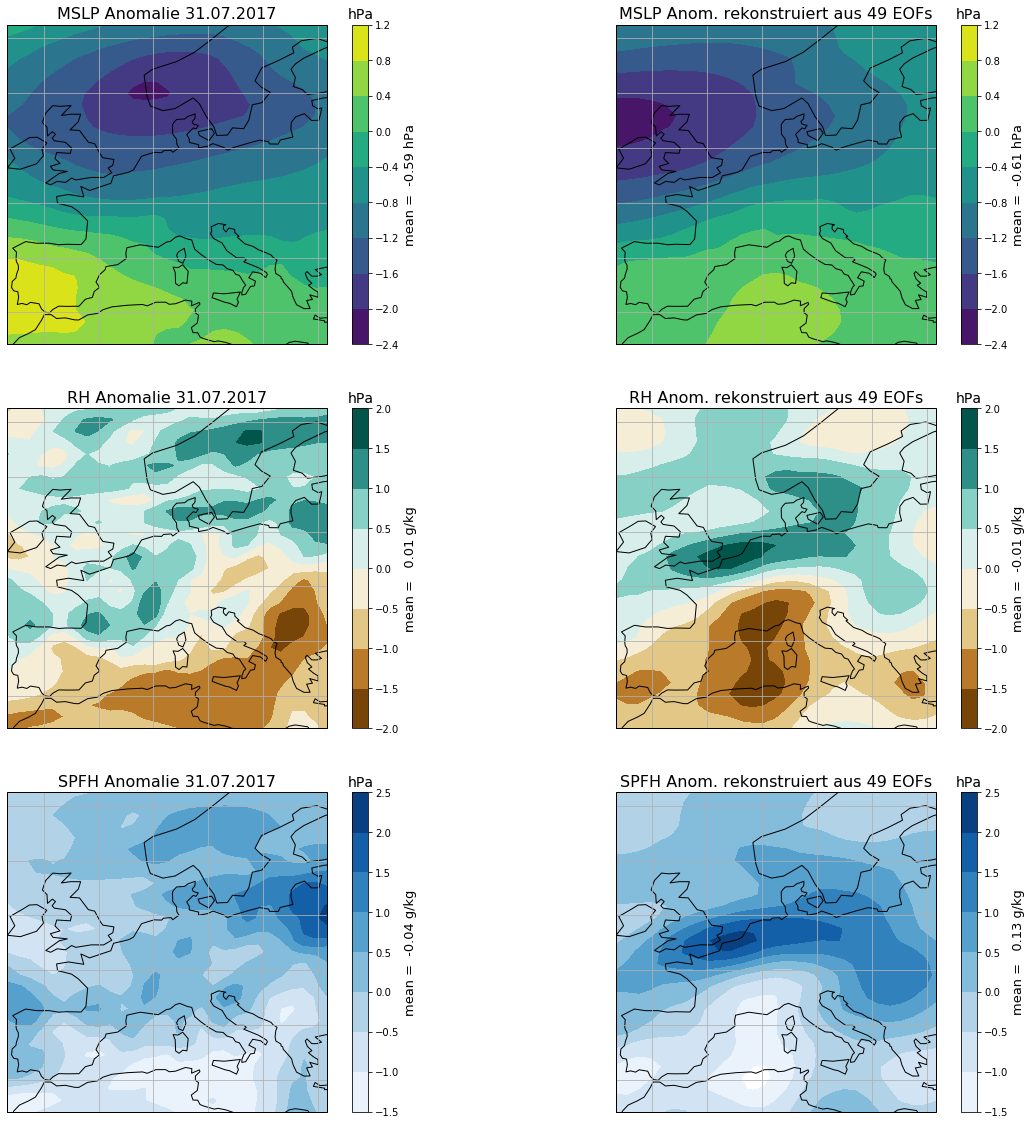

In [320]:
f=plt.figure(figsize=(20,20))

ax = plt.subplot(3,2,1,projection=ccrs.PlateCarree(central_longitude=0))
p = ax.contourf(anomalies_norm.variables['lon'][:],anomalies_norm.variables['lat'][:],anomalies_norm.mslp[21915,:,:],transform=ccrs.PlateCarree())

ax.coastlines()
ax.gridlines()
clb = plt.colorbar(p,ax=ax, orientation='vertical')
clb.ax.set_title('hPa',size=14)
clb.set_label('mean = ' + '{:6.2f}'.format(np.mean(anomalies_norm.mslp[21915,:,:].values)) + ' hPa',size=13)
plt.title('MSLP Anomalie 31.07.2017', fontsize=16)

ax = plt.subplot(3,2,2,projection=ccrs.PlateCarree(central_longitude=0))
clevs = [-2.4,-2.0,-1.6,-1.2,-0.8,-0.4,0,0.4,0.8,1.2]
p = ax.contourf(anomalies_norm.variables['lon'][:],anomalies_norm.variables['lat'][:],mslp_rek,clevs,transform=ccrs.PlateCarree())

ax.coastlines()
ax.gridlines()
clb = plt.colorbar(p,ax=ax, orientation='vertical')
clb.set_label('mean = ' + '{:6.2f}'.format(np.mean(mslp_rek.values)) + ' hPa',size=13)
clb.ax.set_title('hPa',size=14)
plt.title('MSLP Anom. rekonstruiert aus 49 EOFs', fontsize=16)




ax = plt.subplot(3,2,3,projection=ccrs.PlateCarree(central_longitude=0))
p = ax.contourf(anomalies_norm.variables['lon'][:],anomalies_norm.variables['lat'][:],anomalies_norm.rh[21915,:,:],transform=ccrs.PlateCarree(),cmap='BrBG')

ax.coastlines()
ax.gridlines()
clb = plt.colorbar(p,ax=ax, orientation='vertical')
clb.ax.set_title('hPa',size=14)
clb.set_label('mean = ' + '{:6.2f}'.format(np.mean(anomalies_norm.rh[21915,:,:].values)) + ' g/kg',size=13)
plt.title('RH Anomalie 31.07.2017', fontsize=16)

ax = plt.subplot(3,2,4,projection=ccrs.PlateCarree(central_longitude=0))
clevs = [-2,-1.5,-1.0,-0.5,0,0.5,1,1.5,2]
p = ax.contourf(anomalies_norm.variables['lon'][:],anomalies_norm.variables['lat'][:],rh_rek,clevs,transform=ccrs.PlateCarree(),cmap='BrBG')

ax.coastlines()
ax.gridlines()
clb = plt.colorbar(p,ax=ax, orientation='vertical')
clb.set_label('mean = ' + '{:6.2f}'.format(np.mean(rh_rek.values)) + ' g/kg',size=13)
clb.ax.set_title('hPa',size=14)
plt.title('RH Anom. rekonstruiert aus 49 EOFs', fontsize=16)




ax = plt.subplot(3,2,5,projection=ccrs.PlateCarree(central_longitude=0))
p = ax.contourf(anomalies_norm.variables['lon'][:],anomalies_norm.variables['lat'][:],anomalies_norm.spfh[21915,:,:],transform=ccrs.PlateCarree(),cmap='Blues')

ax.coastlines()
ax.gridlines()
clb = plt.colorbar(p,ax=ax, orientation='vertical')
clb.ax.set_title('hPa',size=14)
clb.set_label('mean = ' + '{:6.2f}'.format(np.mean(anomalies_norm.spfh[21915,:,:].values)) + ' g/kg',size=13)
plt.title('SPFH Anomalie 31.07.2017', fontsize=16)

ax = plt.subplot(3,2,6,projection=ccrs.PlateCarree(central_longitude=0))
clevs = [-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5]
p = ax.contourf(anomalies_norm.variables['lon'][:],anomalies_norm.variables['lat'][:],spfh_rek,clevs,transform=ccrs.PlateCarree(),cmap='Blues')

ax.coastlines()
ax.gridlines()
clb = plt.colorbar(p,ax=ax, orientation='vertical')
clb.set_label('mean = ' + '{:6.2f}'.format(np.mean(spfh_rek.values)) + ' g/kg',size=13)
clb.ax.set_title('hPa',size=14)
plt.title('SPFH Anom. rekonstruiert aus 49 EOFs', fontsize=16)

### RMSE

#### Analogon

In [335]:
rmse = np.sqrt( ( np.mean(anomalies_norm.mslp[12060,:,:].values) - np.mean(anomalies_norm.mslp[21915,:,:].values) )**2 )
rmse

0.07852447032928467

In [322]:
rmse2 =np.sqrt( ( np.mean(anomalies_norm.spfh[12060,:,:].values) - np.mean(anomalies_norm.spfh[21915,:,:].values) )**2 )
rmse2

0.029822658747434616

In [323]:
rmse3 =np.sqrt( ( np.mean(anomalies_norm.rh[12060,:,:].values) - np.mean(anomalies_norm.rh[21915,:,:].values) )**2 )
rmse3

0.04412505775690079

In [324]:
(rmse+rmse2+rmse3)/3

0.05082406227787336

#### Rek. Feld

In [326]:
rmse_rek = np.sqrt( ( np.mean(mslp_rek.values) - np.mean(anomalies_norm.mslp[21915,:,:].values) )**2 )
rmse_rek

0.019598722457885742

In [327]:
rmse2_rek =np.sqrt( ( np.mean(spfh_rek.values) - np.mean(anomalies_norm.spfh[21915,:,:].values) )**2 )
rmse2_rek

0.16608594357967377

In [328]:
rmse3_rek =np.sqrt( ( np.mean(rh_rek.values) - np.mean(anomalies_norm.rh[21915,:,:].values) )**2 )
rmse3_rek

0.028175871819257736

In [329]:
(rmse_rek+rmse2_rek+rmse3_rek)/3

0.07128684595227242